# Importación de Bibliotecas

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
import nltk
from scipy.sparse import csr_matrix

# Carga de datos y Preprocesamiento

Importamos el dataset de entrenamiento

In [2]:
df = pd.read_csv("./train.csv")

ds_trabajo = df.copy()
ds_trabajo.head(5)

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


In [3]:
stopwords = nltk.corpus.stopwords.words('spanish')

In [4]:
import re
ds_trabajo.review_es = ds_trabajo.review_es.str.lower();
ds_trabajo.review_es = ds_trabajo.review_es.apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
ds_trabajo.review_es

0        uno de los otros críticos ha mencionado que de...
1        una pequeña pequeña producción la técnica de f...
2        pensé que esta era una manera maravillosa de p...
3        básicamente  hay una familia donde un niño peq...
4        el  amor en el tiempo  de petter mattei es una...
                               ...                        
49995    pensé que esta película hizo un buen trabajo a...
49996    mala parcela  mal diálogo  mala actuación  dir...
49997    soy católica enseñada en escuelas primarias pa...
49998    voy a tener que estar en desacuerdo con el com...
49999    nadie espera que las películas de star trek se...
Name: review_es, Length: 50000, dtype: object

In [6]:
import pandas as pd
import spacy
# from nltk.stem import WordNetLemmatizer
# from nltk.tokenize import word_tokenize

# # Descargar los recursos necesarios de NLTK
# import nltk
# nltk.download('punkt')
# nltk.download('wordnet')

# Cargar el modelo de idioma español en spaCy
nlp = spacy.load('es_core_news_sm')

# Realizar la lematización en la columna 'Texto'
ds_trabajo.review_es = ds_trabajo.review_es.apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))

print(ds_trabajo.review_es)


0        uno de el otro crítico haber mencionar que des...
1        uno pequeño pequeño producción el técnica de f...
2        pensar que este ser uno manera maravilloso de ...
3        básicamente   haber uno familia donde uno niño...
4        el   amor en el tiempo   de petter mattei ser ...
                               ...                        
49995    pensar que este película hacer uno buen trabaj...
49996    malo parcela   mal diálogo   malo actuación   ...
49997    ser católico enseñado en escuela primario parr...
49998    ir a tener que estar en desacuerdo con el come...
49999    nadie esperar que el película de star trek ser...
Name: review_es, Length: 50000, dtype: object


In [ ]:
ds_trabajo.to_csv('train_normalizado.csv', index=False)

# Modelo 1 (overfitteó)

In [7]:
preprocesador = CountVectorizer(stop_words=stopwords)

textos_entrenamiento, textos_prueba, etiquetas_entrenamiento, etiquetas_prueba = train_test_split(ds_trabajo.review_es, ds_trabajo.sentimiento, test_size=0.2, random_state=42)

vectorizador = preprocesador.fit(textos_entrenamiento)
caracteristicas_entrenamiento = vectorizador.transform(textos_entrenamiento)
caracteristicas_prueba = vectorizador.transform(textos_prueba)

modelo = MultinomialNB(alpha=1)
modelo.fit(caracteristicas_entrenamiento, etiquetas_entrenamiento)

predicciones = modelo.predict(caracteristicas_prueba)

print("La accuracy es {}".format(accuracy_score(etiquetas_prueba, predicciones)))
print("La precision es {}".format(precision_score(etiquetas_prueba, predicciones, average='macro')))
print("El recall es {}".format(recall_score(etiquetas_prueba, predicciones, average='macro')))
print("El F1 es {}".format(f1_score(etiquetas_prueba, predicciones, average='macro')))



La accuracy es 0.8366
La precision es 0.8383409388641156
El recall es 0.8368786756986295
El F1 es 0.8364605597316497


Text(50.722222222222214, 0.5, 'True')

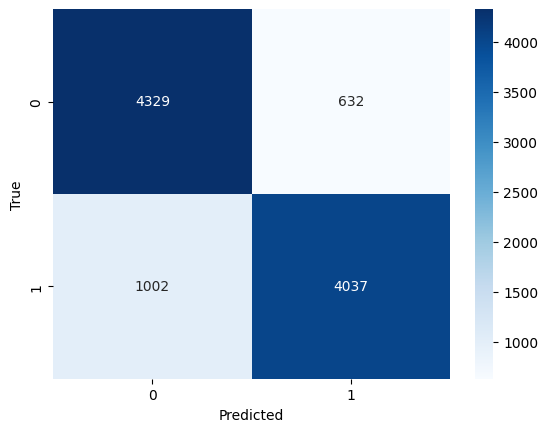

In [8]:
cm = confusion_matrix(etiquetas_prueba,predicciones)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')


In [9]:
import pickle

with open('./models/naive_bayes/nb_model.pickle', 'wb') as archivo:
    pickle.dump(modelo, archivo)

In [10]:
with open('./models/naive_bayes/nb_model.pickle', 'rb') as archivo:
    modelo_cargado = pickle.load(archivo)

ds_test = pd.read_csv('./test.csv')
ds_submission = ds_test.copy()

nuevas_caracteristicas = vectorizador.transform(ds_submission.review_es)
predicciones_nuevas = modelo_cargado.predict(nuevas_caracteristicas)

df_submission = pd.DataFrame({'ID': ds_submission.ID, 'sentimiento': predicciones_nuevas})
df_submission.head()
df_submission.to_csv('submissions/naive_bayes/nb_submission.csv', index=False)

# Modelo 2

In [11]:
X_train, X_test, y_train, y_test = train_test_split(ds_trabajo.review_es, ds_trabajo.sentimiento, test_size=0.2, random_state=42)

# Crear un objeto TfidfVectorizer con stopwords en español
vectorizador = TfidfVectorizer(stop_words=stopwords)

# Ajustar y transformar los datos de entrenamiento
X_train_transformado = vectorizador.fit_transform(X_train)

# Transformar los datos de prueba
X_test_transformado = vectorizador.transform(X_test)

# Crear el modelo Naive Bayes Multinomial
modelo_2 = MultinomialNB()

# Entrenar el modelo con los datos de entrenamiento
modelo_2.fit(X_train_transformado, y_train)

MultinomialNB()

In [12]:
predicciones = modelo_2.predict(X_test_transformado)

print("La accuracy es {}".format(accuracy_score(etiquetas_prueba, predicciones)))
print("La precision es {}".format(precision_score(etiquetas_prueba, predicciones, average='macro')))
print("El recall es {}".format(recall_score(etiquetas_prueba, predicciones, average='macro')))
print("El F1 es {}".format(f1_score(etiquetas_prueba, predicciones, average='macro')))

La accuracy es 0.8506
La precision es 0.8507206112332033
El recall es 0.8506751550764349
El F1 es 0.8505986553878986


Text(50.722222222222214, 0.5, 'True')

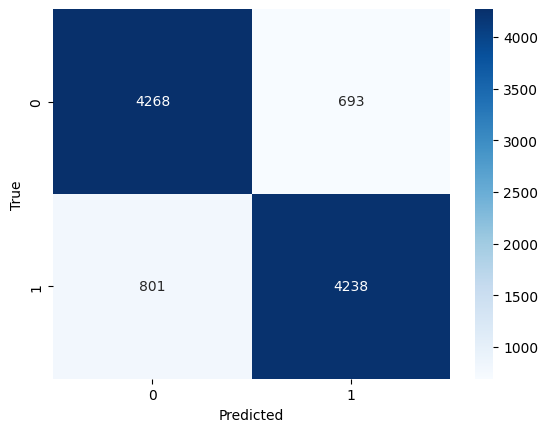

In [13]:
cm = confusion_matrix(etiquetas_prueba,predicciones)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')


In [14]:
import pickle

with open('./models/naive_bayes/nb_model2.pickle', 'wb') as archivo:
    pickle.dump(modelo_2, archivo)

In [15]:
with open('./models/naive_bayes/nb_model2.pickle', 'rb') as archivo:
    modelo_cargado = pickle.load(archivo)

ds_test = pd.read_csv('./test.csv')
ds_submission = ds_test.copy()

nuevas_caracteristicas = vectorizador.transform(ds_submission.review_es)
predicciones_nuevas = modelo_cargado.predict(nuevas_caracteristicas)

df_submission = pd.DataFrame({'ID': ds_submission.ID, 'sentimiento': predicciones_nuevas})
df_submission.head()
df_submission.to_csv('submissions/naive_bayes/nb_submission2.csv', index=False)